# **ADS 502 Final Project - Death Classification**
### Team 5 - Katie Mears, Marvin Moran, Claire Bentzen

## 1. Introduction

##### Load Packages

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#!pip install prince
import prince
from scipy.stats import chi2_contingency
import networkx as nx
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout
import tensorflow as tf
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve

In [34]:
import warnings
warnings.filterwarnings('ignore')

##### Read and Examine Dataset

In [35]:
# Read in 2015_data.csv
death_data = pd.read_csv('/2015_data.csv')

# Display the first few rows of the data
print(death_data.head())

   resident_status  education_1989_revision  education_2003_revision  \
0                1                      NaN                      3.0   
1                1                      NaN                      6.0   
2                1                      NaN                      3.0   
3                1                      NaN                      3.0   
4                1                      NaN                      5.0   

   education_reporting_flag  month_of_death sex  detail_age_type  detail_age  \
0                         1               1   M                1          84   
1                         1               1   M                1          70   
2                         1               1   F                1          91   
3                         1               1   F                1          40   
4                         1               1   F                1          89   

   age_substitution_flag  age_recode_52  ...  record_condition_18  \
0                

In [36]:
# Print shape of data
death_data.shape

(2718198, 77)

In [37]:
# Print Column Titles in Original Data Set
column_titles = death_data.columns
print(column_titles)

Index(['resident_status', 'education_1989_revision', 'education_2003_revision',
       'education_reporting_flag', 'month_of_death', 'sex', 'detail_age_type',
       'detail_age', 'age_substitution_flag', 'age_recode_52', 'age_recode_27',
       'age_recode_12', 'infant_age_recode_22',
       'place_of_death_and_decedents_status', 'marital_status',
       'day_of_week_of_death', 'current_data_year', 'injury_at_work',
       'manner_of_death', 'method_of_disposition', 'autopsy', 'activity_code',
       'place_of_injury_for_causes_w00_y34_except_y06_and_y07_',
       'icd_code_10th_revision', '358_cause_recode', '113_cause_recode',
       '130_infant_cause_recode', '39_cause_recode',
       'number_of_entity_axis_conditions', 'entity_condition_1',
       'entity_condition_2', 'entity_condition_3', 'entity_condition_4',
       'entity_condition_5', 'entity_condition_6', 'entity_condition_7',
       'entity_condition_8', 'entity_condition_9', 'entity_condition_10',
       'entity_condition

In [38]:
# Isolate the Desired Columns
desired_columns = ['education_2003_revision', 'month_of_death', 'sex', 'place_of_death_and_decedents_status',
                   'marital_status', 'day_of_week_of_death', 'injury_at_work', 'manner_of_death', 'method_of_disposition',
                   'autopsy', 'race','detail_age']
new_death = death_data[desired_columns]

# List of column names to convert to categorical
categorical_columns = ['education_2003_revision', 'month_of_death', 'sex', 'place_of_death_and_decedents_status',
                   'marital_status', 'day_of_week_of_death', 'injury_at_work', 'manner_of_death',
                   'method_of_disposition', 'autopsy', 'race']

# Convert the selected columns to categorical
new_death[categorical_columns] = new_death[categorical_columns].astype('category')

In [39]:
# Data Description of original data set with selected columns (2015_data.csv)
data_description_all = new_death.describe(include='all')
print(data_description_all)

        education_2003_revision  month_of_death      sex  \
count                 2645155.0       2718198.0  2718198   
unique                      9.0            12.0        2   
top                         3.0             1.0        M   
freq                  1077604.0        265882.0  1377165   
mean                        NaN             NaN      NaN   
std                         NaN             NaN      NaN   
min                         NaN             NaN      NaN   
25%                         NaN             NaN      NaN   
50%                         NaN             NaN      NaN   
75%                         NaN             NaN      NaN   
max                         NaN             NaN      NaN   

        place_of_death_and_decedents_status marital_status  \
count                             2718198.0        2718198   
unique                                  8.0              5   
top                                     1.0              M   
freq                           

##### Convert response variable to only 2 categories

In [40]:
# Convert manner_of_death to homicide or not homicide
new_death['manner_of_death'] = new_death['manner_of_death'].replace([1, 2, 4, 5, 6, 7, None],0)
new_death['manner_of_death'] = new_death['manner_of_death'].replace([3],1)

## 2. Exploratory Data Analysis

In [41]:
# Get the data types for all columns
data_types = new_death.dtypes

print(data_types)

education_2003_revision                category
month_of_death                         category
sex                                    category
place_of_death_and_decedents_status    category
marital_status                         category
day_of_week_of_death                   category
injury_at_work                         category
manner_of_death                        category
method_of_disposition                  category
autopsy                                category
race                                   category
detail_age                                int64
dtype: object


#### 2.1 Categorical Data Analysis

##### 2.1.1 education_2003_revision

education_2003_revision Frequency:
3.0    1077604
4.0     315364
1.0     290342
2.0     278916
6.0     261106
5.0     154326
9.0     119831
7.0     103978
8.0      43688
Name: education_2003_revision, dtype: int64


<Axes: xlabel='education_2003_revision'>

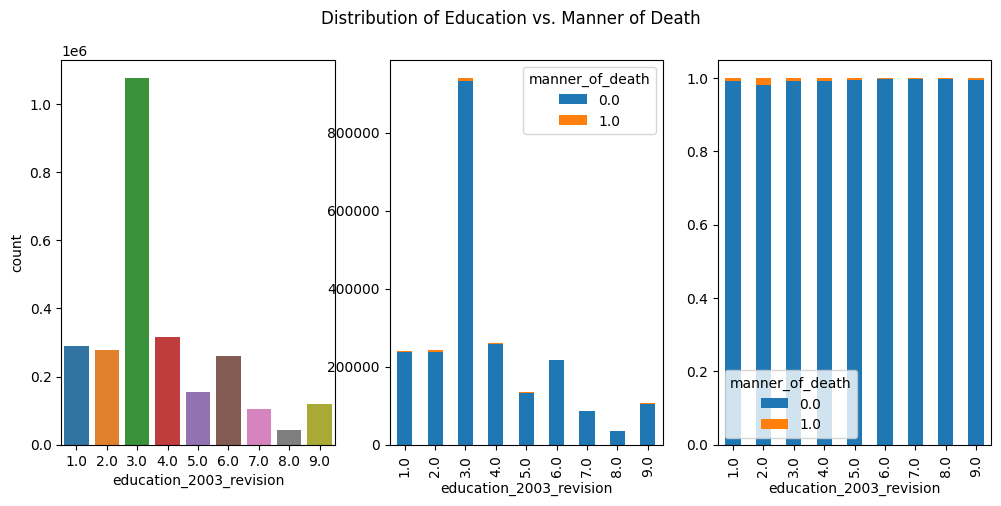

In [42]:
# Value Counts
education_counts = new_death['education_2003_revision'].value_counts()
print("education_2003_revision Frequency:")
print(education_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Education vs. Manner of Death")

# Plot Counts
sns.countplot(x="education_2003_revision", data=new_death, ax=axs[0])

# Plot Counts with Overlay
crosstab_education = pd.crosstab(new_death['education_2003_revision'], new_death['manner_of_death'])
crosstab_education.plot(kind='bar', ax=axs[1], stacked = True)

# Plot Counts with Overlay and Normalization
crosstab_education_norm = crosstab_education.div(crosstab_education.sum(axis=1), axis = 0)
crosstab_education_norm.plot(kind='bar', ax=axs[2], stacked = True)

##### 2.1.2 month_of_death

month_of_death Frequency:
1     265882
3     243174
12    234228
2     227471
4     224841
5     224035
10    223987
11    220234
7     217451
8     214917
6     211631
9     210347
Name: month_of_death, dtype: int64


<Axes: xlabel='month_of_death'>

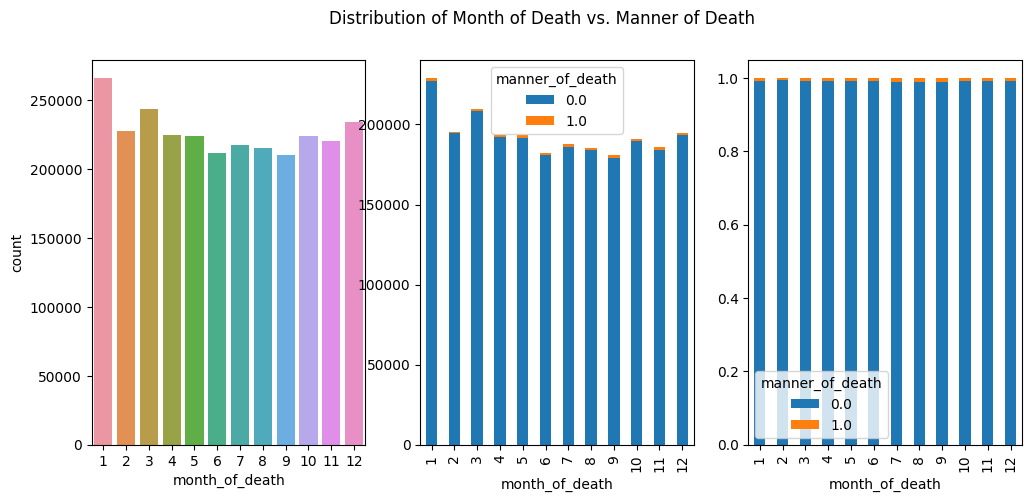

In [43]:
# Value Counts
month_of_death_counts = new_death['month_of_death'].value_counts()
print("month_of_death Frequency:")
print(month_of_death_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Month of Death vs. Manner of Death")

# Plot Counts
sns.countplot(x="month_of_death", data=new_death, ax=axs[0])

# Plot Counts with Overlay
crosstab_month = pd.crosstab(new_death['month_of_death'], new_death['manner_of_death'])
crosstab_month.plot(kind='bar', ax=axs[1], stacked = True)

# Plot Counts with Overlay and Normalization
crosstab_month_norm = crosstab_month.div(crosstab_month.sum(axis=1), axis = 0)
crosstab_month_norm.plot(kind='bar', ax=axs[2], stacked = True)

##### 2.1.3 sex

sex Frequency:
M    1377165
F    1341033
Name: sex, dtype: int64


<Axes: xlabel='sex'>

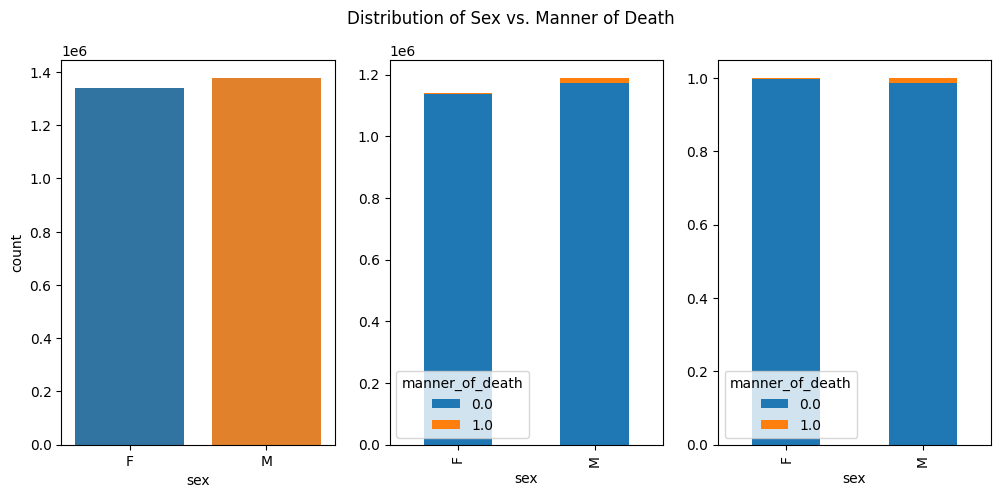

In [44]:
# Value Counts
sex_counts = new_death['sex'].value_counts()
print("sex Frequency:")
print(sex_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Sex vs. Manner of Death")

# Plot Counts
sns.countplot(x="sex", data=new_death, ax=axs[0])

# Plot Counts with Overlay
crosstab_sex = pd.crosstab(new_death['sex'], new_death['manner_of_death'])
crosstab_sex.plot(kind='bar', ax=axs[1], stacked = True)

# Plot Counts with Overlay and Normalization
crosstab_sex_norm = crosstab_sex.div(crosstab_sex.sum(axis=1), axis = 0)
crosstab_sex_norm.plot(kind='bar', ax=axs[2], stacked = True)

##### 2.1.4 place_of_death_and_decedents_status

place_of_death_and_decedents_status Frequency:
1    810446
4    807866
6    538387
5    209848
2    176384
7    161613
3     12364
9      1290
Name: place_of_death_and_decedents_status, dtype: int64


<Axes: xlabel='place_of_death_and_decedents_status'>

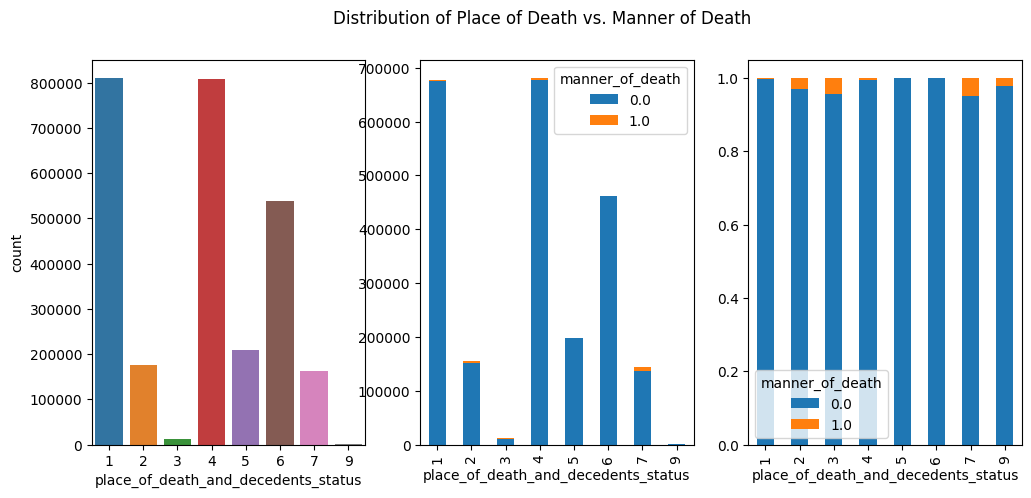

In [45]:
# Value Counts
place_of_death_and_decedents_status_counts = new_death['place_of_death_and_decedents_status'].value_counts()
print("place_of_death_and_decedents_status Frequency:")
print(place_of_death_and_decedents_status_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Place of Death vs. Manner of Death")

# Plot Counts
sns.countplot(x="place_of_death_and_decedents_status", data=new_death, ax=axs[0])

# Plot Counts with Overlay
crosstab_place_of_death_and_decedents_status = pd.crosstab(new_death['place_of_death_and_decedents_status'], new_death['manner_of_death'])
crosstab_place_of_death_and_decedents_status.plot(kind='bar', ax=axs[1], stacked = True)

# Plot Counts with Overlay and Normalization
crosstab_place_of_death_and_decedents_status_norm = crosstab_place_of_death_and_decedents_status.div(crosstab_place_of_death_and_decedents_status.sum(axis=1), axis = 0)
crosstab_place_of_death_and_decedents_status_norm.plot(kind='bar', ax=axs[2], stacked = True)

##### 2.1.5 marital_status

marital_status Frequency:
M    1002482
W     922000
D     422289
S     351323
U      20104
Name: marital_status, dtype: int64


<Axes: xlabel='marital_status'>

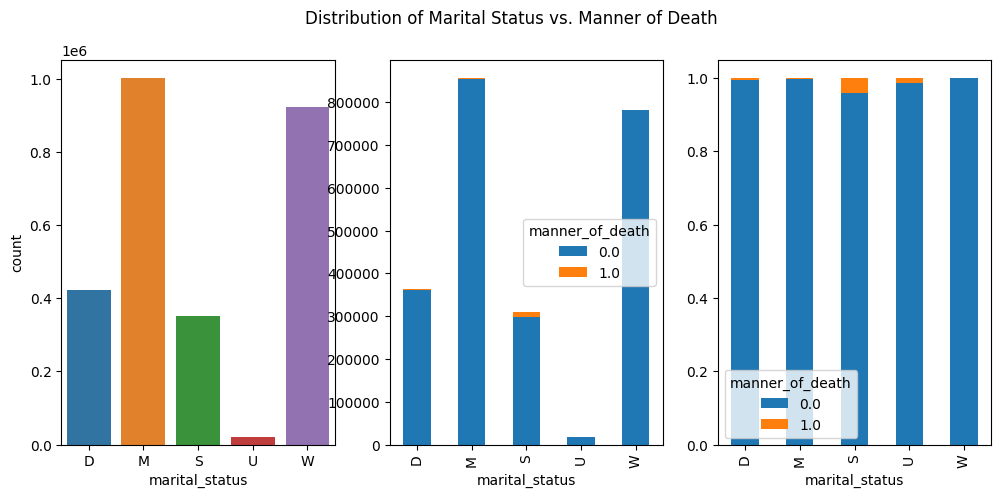

In [46]:
# Value Counts
marital_status_counts = new_death['marital_status'].value_counts()
print("marital_status Frequency:")
print(marital_status_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Marital Status vs. Manner of Death")

# Plot Counts
sns.countplot(x="marital_status", data=new_death, ax=axs[0])

# Plot Counts with Overlay
crosstab_marital_status = pd.crosstab(new_death['marital_status'], new_death['manner_of_death'])
crosstab_marital_status.plot(kind='bar', ax=axs[1], stacked = True)

# Plot Counts with Overlay and Normalization
crosstab_marital_status_norm = crosstab_marital_status.div(crosstab_marital_status.sum(axis=1), axis = 0)
crosstab_marital_status_norm.plot(kind='bar', ax=axs[2], stacked = True)

##### 2.1.6 day_of_week_of_death

day_of_week_of_death Frequency:
5    394527
7    390248
6    389872
2    387379
1    386109
3    384990
4    384936
9       137
Name: day_of_week_of_death, dtype: int64


<Axes: xlabel='day_of_week_of_death'>

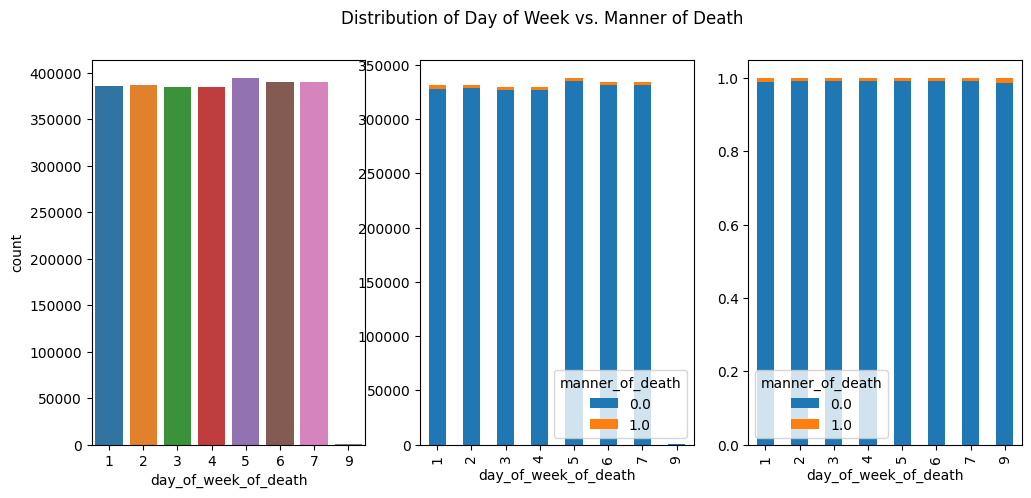

In [47]:
# Value Counts
day_of_week_of_death_counts = new_death['day_of_week_of_death'].value_counts()
print("day_of_week_of_death Frequency:")
print(day_of_week_of_death_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Day of Week vs. Manner of Death")

# Plot Counts
sns.countplot(x="day_of_week_of_death", data=new_death, ax=axs[0])

# Plot Counts with Overlay
crosstab_day_of_week_of_death = pd.crosstab(new_death['day_of_week_of_death'], new_death['manner_of_death'])
crosstab_day_of_week_of_death.plot(kind='bar', ax=axs[1], stacked = True)

# Plot Counts with Overlay and Normalization
crosstab_day_of_week_of_death_norm = crosstab_day_of_week_of_death.div(crosstab_day_of_week_of_death.sum(axis=1), axis = 0)
crosstab_day_of_week_of_death_norm.plot(kind='bar', ax=axs[2], stacked = True)

##### 2.1.7 injury_at_work

injury_at_work Frequency:
U    2498067
N     215884
Y       4247
Name: injury_at_work, dtype: int64


<Axes: xlabel='injury_at_work'>

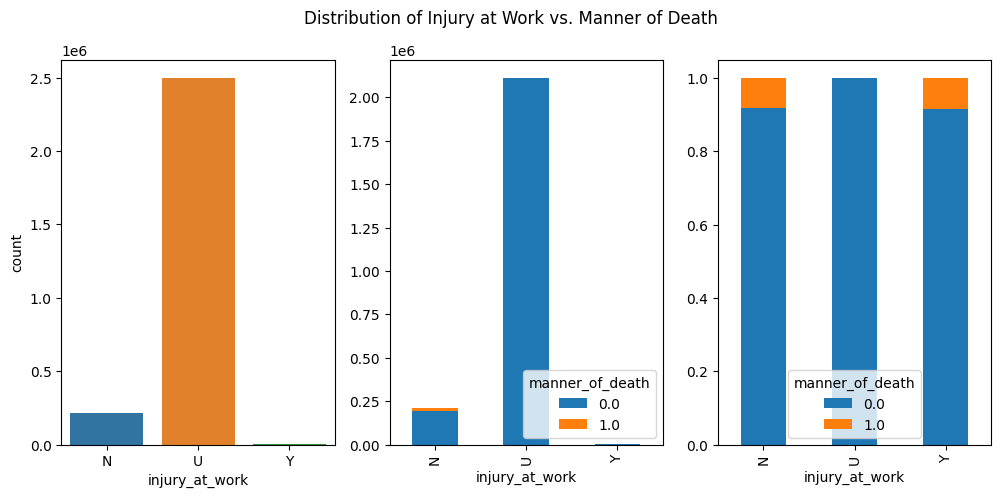

In [48]:
# Value Counts
injury_at_work_counts = new_death['injury_at_work'].value_counts()
print("injury_at_work Frequency:")
print(injury_at_work_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Injury at Work vs. Manner of Death")

# Plot Counts
sns.countplot(x="injury_at_work", data=new_death, ax=axs[0])

# Plot Counts with Overlay
crosstab_injury_at_work = pd.crosstab(new_death['injury_at_work'], new_death['manner_of_death'])
crosstab_injury_at_work.plot(kind='bar', ax=axs[1], stacked = True)

# Plot Counts with Overlay and Normalization
crosstab_injury_at_work_norm = crosstab_injury_at_work.div(crosstab_injury_at_work.sum(axis=1), axis = 0)
crosstab_injury_at_work_norm.plot(kind='bar', ax=axs[2], stacked = True)

##### 2.1.8 method_of_disposition

method_of_disposition Frequency:
B    1247628
C    1244297
U      74050
R      71744
E      40880
D      27870
O      11729
Name: method_of_disposition, dtype: int64


<Axes: xlabel='method_of_disposition'>

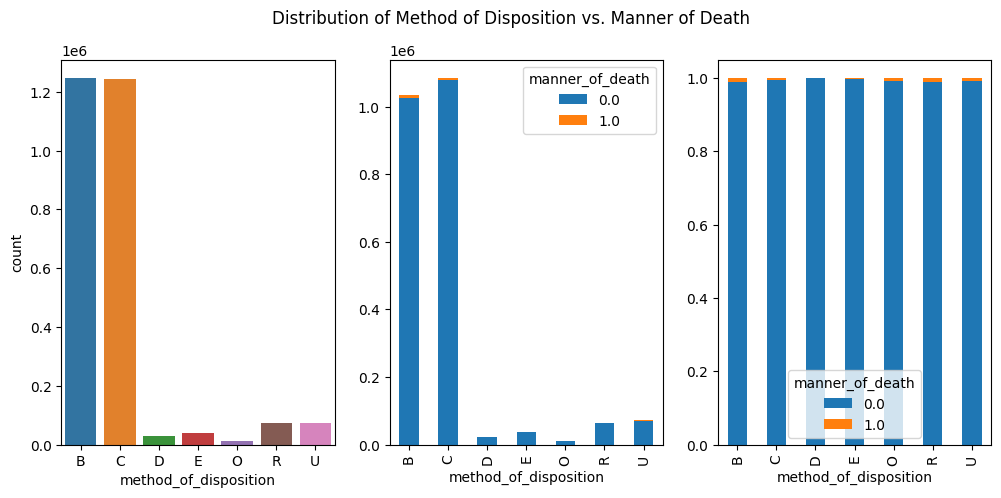

In [49]:
# Value Counts
method_of_disposition_counts = new_death['method_of_disposition'].value_counts()
print("method_of_disposition Frequency:")
print(method_of_disposition_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Method of Disposition vs. Manner of Death")

# Plot Counts
sns.countplot(x="method_of_disposition", data=new_death, ax=axs[0])

# Plot Counts with Overlay
crosstab_method_of_disposition = pd.crosstab(new_death['method_of_disposition'], new_death['manner_of_death'])
crosstab_method_of_disposition.plot(kind='bar', ax=axs[1], stacked = True)

# Plot Counts with Overlay and Normalization
crosstab_method_of_disposition_norm = crosstab_method_of_disposition.div(crosstab_method_of_disposition.sum(axis=1), axis = 0)
crosstab_method_of_disposition_norm.plot(kind='bar', ax=axs[2], stacked = True)

##### 2.1.9 autopsy

autopsy Frequency:
N    2321726
Y     207803
U     188669
Name: autopsy, dtype: int64


<Axes: xlabel='autopsy'>

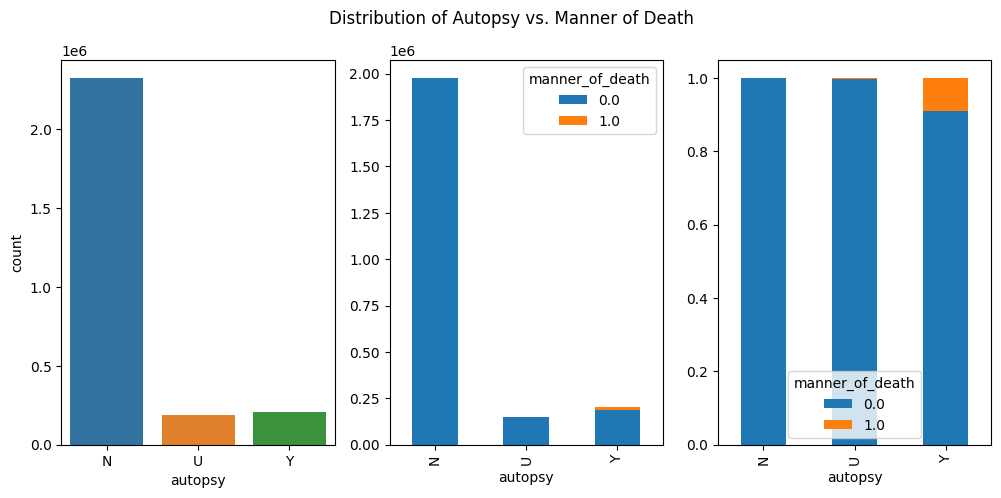

In [50]:
# Value Counts
autopsy_counts = new_death['autopsy'].value_counts()
print("autopsy Frequency:")
print(autopsy_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Autopsy vs. Manner of Death")

# Plot Counts
sns.countplot(x="autopsy", data=new_death, ax=axs[0])

# Plot Counts with Overlay
crosstab_autopsy = pd.crosstab(new_death['autopsy'], new_death['manner_of_death'])
crosstab_autopsy.plot(kind='bar', ax=axs[1], stacked = True)

# Plot Counts with Overlay and Normalization
crosstab_autopsy_norm = crosstab_autopsy.div(crosstab_autopsy.sum(axis=1), axis = 0)
crosstab_autopsy_norm.plot(kind='bar', ax=axs[2], stacked = True)

##### 2.1.10 race

race Frequency:
1     2311103
2      320759
3       19041
4       14526
7       12041
5        8512
68       8220
18       8131
48       5568
28       5371
78       3101
6         749
38        685
58        391
Name: race, dtype: int64


<Axes: xlabel='race'>

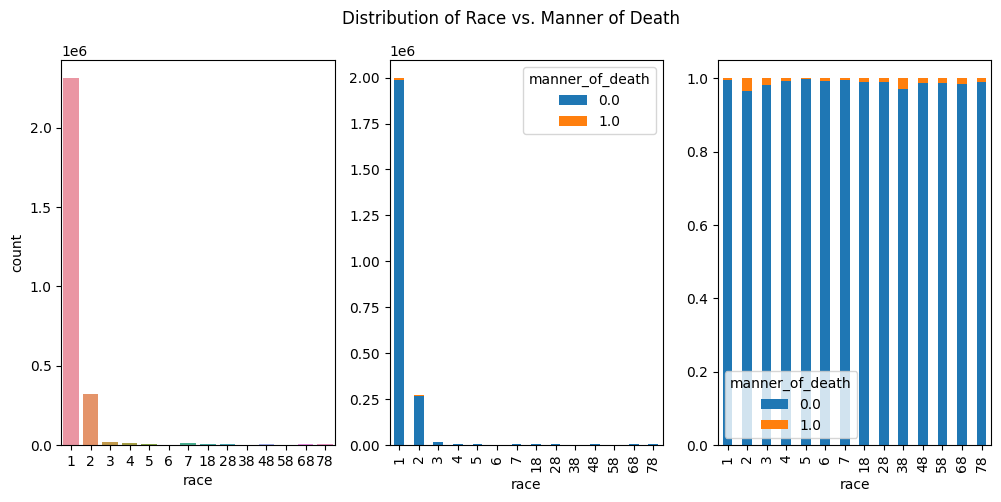

In [51]:
# Value Counts
race_counts = new_death['race'].value_counts()
print("race Frequency:")
print(race_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Race vs. Manner of Death")

# Plot Counts
sns.countplot(x="race", data=new_death, ax=axs[0])

# Plot Counts with Overlay
crosstab_race = pd.crosstab(new_death['race'], new_death['manner_of_death'])
crosstab_race.plot(kind='bar', ax=axs[1], stacked = True)

crosstab_race_norm = crosstab_race.div(crosstab_race.sum(axis=1), axis = 0)
crosstab_race_norm.plot(kind='bar', ax=axs[2], stacked = True)

##### 2.1.11 manner_of_death

manner_of_death Frequency:
0.0    2310949
1.0      18885
Name: manner_of_death, dtype: int64


<Axes: xlabel='manner_of_death', ylabel='count'>

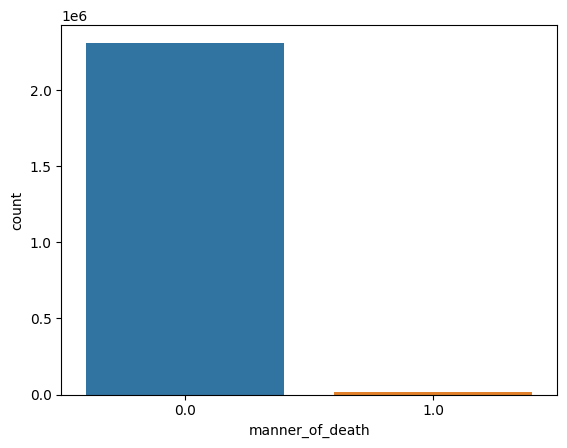

In [52]:
# Value Counts
manner_of_death_counts = new_death['manner_of_death'].value_counts()
print("manner_of_death Frequency:")
print(manner_of_death_counts)

# Plot Counts
sns.countplot(x="manner_of_death", data=new_death)

#### 2.2 Numerical Data Analysis

2.2.1 detail_age

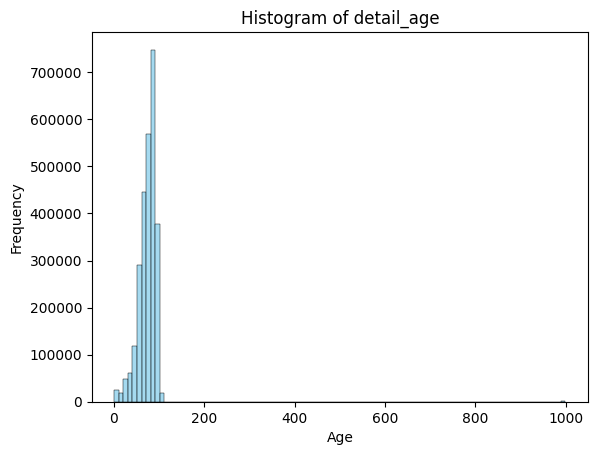

In [53]:
detail_age = new_death['detail_age']
sns.histplot(detail_age, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of detail_age')
plt.show()

There are outliers that are causing a non-representative view of the age distribution. We will remove the outliers.

In [54]:
# Compute z-score for every data point in detail_age
new_death['z_detail_age'] = (new_death['detail_age']-new_death['detail_age'].mean())/new_death['detail_age'].std()
print('Number of rows before discarding outliers = %d' % (new_death.shape[0]))

# Removes rows with a zscore beyond 3 or -3
new_death = new_death[(new_death['z_detail_age'] <= 3) & (new_death['z_detail_age'] >= -3)]
print('Number of rows after discarding missing values = %d' % (new_death.shape[0]))

# Drop the 'C' column
column_name = 'z_detail_age'
new_death.drop(column_name, axis=1, inplace=True)

Number of rows before discarding outliers = 2718198
Number of rows after discarding missing values = 2696935


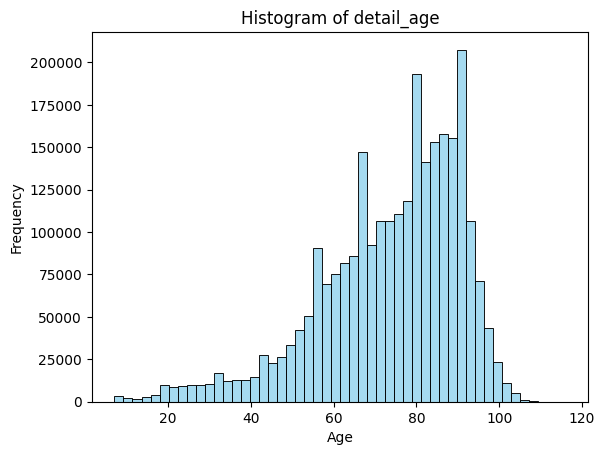

In [55]:
# Plot a Histogram for detail_age
detail_age = new_death['detail_age']
sns.histplot(detail_age, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of detail_age')
plt.show()

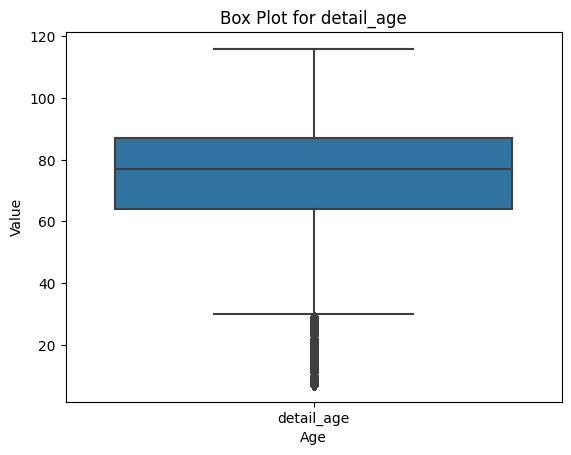

In [56]:
# Plot a Box Plot for detail_age
sns.boxplot(data=new_death[['detail_age']])
plt.xlabel('Age')
plt.ylabel('Value')
plt.title("Box Plot for detail_age")
plt.show()

<Axes: xlabel='detail_age', ylabel='manner_of_death'>

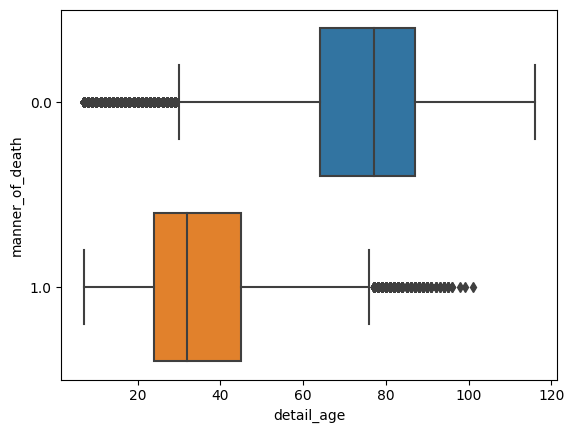

In [57]:
# Plot a Box Plot for detail_age grouped by manner_of_death
sns.boxplot(x="detail_age", y="manner_of_death", data=new_death)

## 3. Data Preprocessing

#### 3.1 Missing Data

In [13]:
# Print Missing Values per Column
missing_values_count = new_death.isnull().sum()
print(missing_values_count)

education_2003_revision                 72512
month_of_death                              0
sex                                         0
place_of_death_and_decedents_status         0
marital_status                              0
day_of_week_of_death                        0
injury_at_work                              0
manner_of_death                        385913
method_of_disposition                       0
autopsy                                     0
race                                        0
detail_age                                  0
dtype: int64


In [14]:
# Print Missing Data as percentage (per column)
total_rows = new_death.shape[0]
percent_missing = (missing_values_count / total_rows) * 100
print(percent_missing)

education_2003_revision                 2.688682
month_of_death                          0.000000
sex                                     0.000000
place_of_death_and_decedents_status     0.000000
marital_status                          0.000000
day_of_week_of_death                    0.000000
injury_at_work                          0.000000
manner_of_death                        14.309318
method_of_disposition                   0.000000
autopsy                                 0.000000
race                                    0.000000
detail_age                              0.000000
dtype: float64


In [15]:
# Print Total Percent of Missing Data
total_missing_values = new_death.isnull().sum().sum()
total_elements = new_death.size
total_percent_missing = (total_missing_values / total_elements) * 100
print("Total percentage of missing data in the dataset: {:.2f}%".format(total_percent_missing))

Total percentage of missing data in the dataset: 1.42%


In [17]:
# Drop rows with missing values
death_dropped = new_death.dropna()

In [19]:
# Check Missing Values were Dropped
total_missing_values3 = death_dropped.isnull().sum().sum()
total_elements3 = death_dropped.size
total_percent_missing3 = (total_missing_values3 / total_elements3) * 100
print("Total percentage of missing data in the sample dataset: {:.2f}%".format(total_percent_missing3))

Total percentage of missing data in the sample dataset: 0.00%


#### 3.2 Random Sample

In [21]:
# Perform random sampling
sampled_df = death_dropped.sample(frac=0.3, random_state=1)
print('Number of rows after random sampling = %d' % (sampled_df.shape[0]))

Number of rows after random sampling = 672295


#### 2.3 Correlations

In [27]:
sampled_df = sampled_df.dropna()

##### 2.3.1 Multiple Component Analysis

In [29]:
for column in sampled_df.columns:
    sampled_df[column] = pd.Categorical(sampled_df[column]).codes

# Perform MCA
mca = prince.MCA(n_components=16)
mca.fit(sampled_df)

# Access the eigenvalues and calculate the explained variance ratio
eigenvalues = mca.eigenvalues_
total_variance = sum(eigenvalues)
explained_variance_ratio = eigenvalues / total_variance

# Access the results
print("Eigenvalues:")
print(mca.eigenvalues_)


print("\nExplained Variance Ratio:")
print(explained_variance_ratio)


print("\nPrincipal Coordinates:")
print(mca.row_coordinates(sampled_df))  # Coordinates of rows (observations)
print(mca.column_coordinates(sampled_df))  # Coordinates of columns (categories)


Eigenvalues:
[0.22901597 0.15398961 0.11131121 0.10813954 0.10246323 0.09149221
 0.0878012  0.08746206 0.08721657 0.08572204 0.08508074 0.08490651
 0.08435209 0.0842308  0.08391895 0.08385163]

Explained Variance Ratio:
[0.13871733 0.09327309 0.06742234 0.06550123 0.06206303 0.05541777
 0.05318209 0.05297667 0.05282797 0.05192272 0.05153428 0.05142875
 0.05109293 0.05101946 0.05083057 0.05078979]

Principal Coordinates:
               0         1         2         3         4         5         6   \
1866568  1.640872  0.842304  0.082159 -0.181448 -0.082616 -0.706495  0.180780   
2005314 -0.343148  0.126359 -0.091484 -0.107779 -0.047227 -0.210330 -0.276587   
568788  -0.261628 -0.027322 -0.096632  0.009755 -0.170758  0.008031 -0.047553   
1632843 -0.175532 -0.113346 -0.120725 -0.025848  0.109287  0.181503  0.051696   
1724346 -0.111289  0.614082 -0.207780  0.968186  0.182082 -0.082093 -0.062424   
...           ...       ...       ...       ...       ...       ...       ...   
1947117 -

In [ ]:
# Plot MCA results
plt.figure(figsize=(10, 6))
plt.scatter(mca.row_coordinates(sampled_df).iloc[:, 0], mca.row_coordinates(sampled_df).iloc[:, 1], label='Rows')
plt.scatter(mca.column_coordinates(sampled_df).iloc[:, 0], mca.column_coordinates(sampled_df).iloc[:, 1], label='Columns')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.title('MCA Results')
plt.grid()
plt.show()

##### 2.3.2 Cramer's V

In [ ]:
# Convert the categorical data to numerical labels (optional if already numeric)
for column in sampled_df.columns:
    sampled_df[column] = pd.Categorical(sampled_df[column]).codes

# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['detail_age'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

In [ ]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['race'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

In [ ]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['sex'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

In [ ]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['autopsy'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

In [ ]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['marital_status'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

In [ ]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['month_of_death'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

In [ ]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['education_2003_revision'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

In [ ]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['day_of_week_of_death'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

In [ ]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['injury_at_work'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

In [ ]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['method_of_disposition'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

In [ ]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['injury_at_work'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

In [ ]:
# Plot MCA results
plt.figure(figsize=(10, 6))

# Scatter plot for rows with different colors
row_coords = mca.row_coordinates(sampled_df)
plt.scatter(row_coords.iloc[:, 0], row_coords.iloc[:, 1], c='blue', label='Rows')

# Scatter plot for columns with different colors
column_coords = mca.column_coordinates(sampled_df)
num_categories = column_coords.shape[0]
colors = plt.cm.tab20(np.arange(num_categories))  # Using tab20 colormap with 20 colors
plt.scatter(column_coords.iloc[:, 0], column_coords.iloc[:, 1], c=colors, marker='D', label='Columns')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.title('MCA Results')
plt.grid()
plt.show()

#### 3.3 Normalize Data and Encode Categorical Variables

In [22]:
# Normalize detail_age using Min-Max scaler
mms = MinMaxScaler()
sampled_df[['detail_age']] = mms.fit_transform(sampled_df[['detail_age']])

In [23]:
# Perform one-hot encoding on categorical columns
encoded_df = pd.get_dummies(sampled_df, columns=['education_2003_revision', 'month_of_death', 'sex', 'place_of_death_and_decedents_status', 'marital_status', 'day_of_week_of_death', 'injury_at_work','method_of_disposition', 'autopsy', 'race'],
                            prefix=['education_2003_revision', 'month_of_death', 'sex', 'place_of_death_and_decedents_status', 'marital_status', 'day_of_week_of_death', 'injury_at_work','method_of_disposition', 'autopsy', 'race'])

#### 3.4 Class Imbalances

In [24]:
# Calculate class proportions
class_proportions = encoded_df['manner_of_death'].value_counts(normalize=True)

print(class_proportions)

0.0    0.992131
1.0    0.007869
Name: manner_of_death, dtype: float64


In [25]:
# Split data for rebalancing
train, test = train_test_split(encoded_df, test_size=0.3, random_state=42)

In [26]:
# Identify current proportion of homicide records
total = train.shape[0]
print('\nTotal number of instances in train sample: ', total)

homicide = train['manner_of_death'].value_counts()[1]
print('\nTotal number of homicide instances in train sample: ', homicide)

# Calculate number to resample
x = ((0.2 * total) - homicide) / 0.8
print('\nNumber of homicide records to resample: ', int(x))

# Resample data to increase number of homicide records
to_resample = train.loc[train['manner_of_death'] == 1]
our_resample = to_resample.sample(n = int(x), replace = True)
encoded_df_rebal = pd.concat([train, our_resample])
encoded_df_rebal['manner_of_death'].value_counts()

# Check percentage is met
ratio = encoded_df_rebal['manner_of_death'].value_counts()[1] / encoded_df_rebal.shape[0] * 100
print('\nNew percent of homicide records: ', round(ratio, 0))


Total number of instances in train sample:  470606

Total number of homicide instances in train sample:  3746

Number of homicide records to resample:  112969

New percent of homicide records:  20.0


## 4. Modeling - Artifical Neural Networks

#### 4.1 ANN Models WITHOUT Data Rebalance

In [30]:
# select features for model
selected_features = [col for col in encoded_df.columns if col != 'manner_of_death']

target_variable = 'manner_of_death'

In [31]:
# select X and y variables
X = encoded_df[selected_features]
y = encoded_df[target_variable]

In [32]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##### 4.1.1 Basic ANN Model withOUT Hidden Layers

In [ ]:
# build the ANN model
model_nolay = keras.Sequential([
    layers.Dense(1, activation='sigmoid', input_shape=(X_train.shape[1],))
])

# compile the model
model_nolay.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train the model
model_nolay.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
418/418 [==============================] - 2s 2ms/step - loss: 0.2547 - accuracy: 0.9530
Epoch 2/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0663 - accuracy: 0.9924
Epoch 3/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0447 - accuracy: 0.9924
Epoch 4/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0369 - accuracy: 0.9924
Epoch 5/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0325 - accuracy: 0.9924
Epoch 6/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0293 - accuracy: 0.9924
Epoch 7/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0269 - accuracy: 0.9924
Epoch 8/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0251 - accuracy: 0.9924
Epoch 9/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0236 - accuracy: 0.9924
Epoch 10/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0224 - accuracy: 0.9924

In [ ]:
# evaluate the model
loss_nolay, accuracy_nolay = model_nolay.evaluate(X_test, y_test)
print(f"Test accuracy (Model_nolay): {accuracy_nolay}")

179/179 [==============================] - 0s 2ms/step - loss: 0.0210 - accuracy: 0.9930
Test accuracy (Model_nolay): 0.9930094480514526


##### 4.1.2 Basic ANN Model with Hidden Layers

In [ ]:
# build the ANN model --> 3 hidden layers, 64 neurons on 1st, 32 neurons on 2nd, and 1 output neuron on last
model_lay = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_lay.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train the ANN model
model_lay.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
418/418 [==============================] - 2s 2ms/step - loss: 0.0461 - accuracy: 0.9899
Epoch 2/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0188 - accuracy: 0.9925
Epoch 3/10
418/418 [==============================] - 1s 3ms/step - loss: 0.0173 - accuracy: 0.9934
Epoch 4/10
418/418 [==============================] - 1s 3ms/step - loss: 0.0158 - accuracy: 0.9934
Epoch 5/10
418/418 [==============================] - 1s 3ms/step - loss: 0.0147 - accuracy: 0.9940
Epoch 6/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0135 - accuracy: 0.9945
Epoch 7/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0123 - accuracy: 0.9950
Epoch 8/10
418/418 [==============================] - 1s 3ms/step - loss: 0.0115 - accuracy: 0.9954
Epoch 9/10
418/418 [==============================] - 1s 3ms/step - loss: 0.0096 - accuracy: 0.9962
Epoch 10/10
418/418 [==============================] - 1s 3ms/step - loss: 0.0084 - accuracy: 0.9969

In [ ]:
# evaluate the model
loss_lay, accuracy_lay = model_lay.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy_lay}")

179/179 [==============================] - 1s 2ms/step - loss: 0.0250 - accuracy: 0.9928
Test accuracy: 0.9928346872329712


In [ ]:
# visualize the ANN model
def visualize_model(model_lay):
    G = nx.DiGraph()
    node_labels = {}
    for i, layer in enumerate(model_lay.layers):
        layer_name = f'{layer.name}\n{layer.output_shape}'
        node_labels[i] = layer_name
        G.add_node(layer_name)
        if i > 0:
            G.add_edge(node_labels[i - 1], layer_name)

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
    plt.title("Neural Network Model Architecture")
    plt.savefig('model_visualization.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

# Call the function to visualize the model
visualize_model(model_lay)

##### 4.1.3 ANN Model w/ Reduced Complexity (Reduced amount of hidden layers)

In [ ]:
# build model with reduced complexity --> 3 hidden layers, 32 neurons on 1st, 16 neurons on 2nd, and 1 output neuron on last
model_red = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# compile the model
model_red.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train the model with reduced complexity
model_red.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
418/418 [==============================] - 2s 3ms/step - loss: 0.0936 - accuracy: 0.9626
Epoch 2/10
418/418 [==============================] - 1s 3ms/step - loss: 0.0209 - accuracy: 0.9924
Epoch 3/10
418/418 [==============================] - 1s 3ms/step - loss: 0.0187 - accuracy: 0.9924
Epoch 4/10
418/418 [==============================] - 1s 3ms/step - loss: 0.0178 - accuracy: 0.9924
Epoch 5/10
418/418 [==============================] - 1s 3ms/step - loss: 0.0170 - accuracy: 0.9923
Epoch 6/10
418/418 [==============================] - 1s 3ms/step - loss: 0.0162 - accuracy: 0.9926
Epoch 7/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0155 - accuracy: 0.9935
Epoch 8/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0149 - accuracy: 0.9939
Epoch 9/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0142 - accuracy: 0.9942
Epoch 10/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0131 - accuracy: 0.9946

In [ ]:
# evaluate the model with reduced complexity
loss_red, accuracy_red = model_red.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy_red}")

179/179 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9934
Test accuracy: 0.9933589696884155


In [ ]:
# visualize model with reduced complexity
def visualize_model(model_red):
    G = nx.DiGraph()
    node_labels = {}
    for i, layer in enumerate(model_red.layers):
        layer_name = f'{layer.name}\n{layer.output_shape}'
        node_labels[i] = layer_name
        G.add_node(layer_name)
        if i > 0:
            G.add_edge(node_labels[i - 1], layer_name)

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
    plt.title("Neural Network Model Architecture (Reduced Complexity)")
    plt.savefig('model_red_visualization.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

# call function to visualize
visualize_model(model_red)

##### 4.1.4 ANN Model with Regularization

In [ ]:
# build ANN the model with minimal hidden layers and dropout regularization (discussed in textbook)
model_reg = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),  # Dropout layer with 20% dropout rate
    layers.Dense(1, activation='sigmoid')  # Binary classification, hence using 'sigmoid'
])

# Compile the model
model_reg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train model
model_reg.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
418/418 [==============================] - 2s 3ms/step - loss: 0.1365 - accuracy: 0.9604
Epoch 2/10
418/418 [==============================] - 2s 4ms/step - loss: 0.0302 - accuracy: 0.9924
Epoch 3/10
418/418 [==============================] - 1s 3ms/step - loss: 0.0231 - accuracy: 0.9924
Epoch 4/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0210 - accuracy: 0.9926
Epoch 5/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0195 - accuracy: 0.9933
Epoch 6/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0195 - accuracy: 0.9930
Epoch 7/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0187 - accuracy: 0.9930
Epoch 8/10
418/418 [==============================] - 1s 3ms/step - loss: 0.0183 - accuracy: 0.9933
Epoch 9/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0180 - accuracy: 0.9937
Epoch 10/10
418/418 [==============================] - 1s 2ms/step - loss: 0.0173 - accuracy: 0.9935

In [ ]:
# evaluate model
loss_reg, accuracy_reg = model_reg.evaluate(X_test, y_test)
print(f"Test accuracy (Model_reg): {accuracy_reg}")

179/179 [==============================] - 0s 2ms/step - loss: 0.0176 - accuracy: 0.9932
Test accuracy (Model_reg): 0.9931842088699341


In [ ]:
# visualize model with dropout reg
def visualize_model(model):
    G = nx.DiGraph()
    node_labels = {}
    for i, layer in enumerate(model.layers):
        layer_name = f'{layer.name}\n{layer.output_shape}'
        node_labels[i] = layer_name
        G.add_node(layer_name)
        if i > 0:
            G.add_edge(node_labels[i - 1], layer_name)

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
    plt.title("Neural Network Model Architecture (Model_reg)")
    plt.savefig('model_reg_visualization.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

# call function to visualize
visualize_model(model_reg)

#### 4.2 ANN Models WITH Data Rebalance

In [ ]:
# select features for model
selected_features = [col for col in encoded_df_rebal.columns if col != 'manner_of_death']

target_variable = 'manner_of_death'

In [ ]:
# select X and y variables
X_rebal = encoded_df_rebal[selected_features]
y_rebal = encoded_df_rebal[target_variable]

In [ ]:
# split data
X_train_rebal, X_test_rebal, y_train_rebal, y_test_rebal = train_test_split(X_rebal, y_rebal, test_size=0.3, random_state=42)

##### 4.2.1 Basic ANN Model withOUT Hidden Layers

In [ ]:
# build the ANN model
model_nolay_rebal = keras.Sequential([
    layers.Dense(1, activation='sigmoid', input_shape=(X_train_rebal.shape[1],))
])

# compile the model
model_nolay_rebal.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train the model
model_nolay_rebal.fit(X_train_rebal, y_train_rebal, epochs=10, batch_size=32)

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4321 - accuracy: 0.8153
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 0.2361 - accuracy: 0.9174
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.1733 - accuracy: 0.9373
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.1428 - accuracy: 0.9548
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.1255 - accuracy: 0.9633
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.1143 - accuracy: 0.9658
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.1066 - accuracy: 0.9658
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.1010 - accuracy: 0.9663
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.0968 - accuracy: 0.9661
Epoch 10/10
363/363 [==============================] - 1s 2ms/step - loss: 0.0936 - accuracy: 0.9664

In [ ]:
# evaluate the model
loss_nolay_rebal, accuracy_nolay_rebal = model_nolay_rebal.evaluate(X_test_rebal, y_test_rebal)
print(f"Test accuracy (Model_nolay): {accuracy_nolay_rebal}")

156/156 [==============================] - 0s 1ms/step - loss: 0.0917 - accuracy: 0.9662
Test accuracy (Model_nolay): 0.966183602809906


##### 4.2.2 Basic ANN Model with Hidden Layers

In [ ]:
# build the ANN model --> 3 hidden layers, 64 neurons on 1st, 32 neurons on 2nd, and 1 output neuron on last
model_lay_rebal = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_rebal.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_lay_rebal.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train the ANN model
model_lay_rebal.fit(X_train_rebal, y_train_rebal, epochs=10, batch_size=32)

Epoch 1/10
363/363 [==============================] - 2s 3ms/step - loss: 0.1458 - accuracy: 0.9381
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 0.0533 - accuracy: 0.9833
Epoch 3/10
363/363 [==============================] - 1s 4ms/step - loss: 0.0375 - accuracy: 0.9890
Epoch 4/10
363/363 [==============================] - 1s 4ms/step - loss: 0.0276 - accuracy: 0.9930
Epoch 5/10
363/363 [==============================] - 1s 3ms/step - loss: 0.0201 - accuracy: 0.9952
Epoch 6/10
363/363 [==============================] - 1s 3ms/step - loss: 0.0150 - accuracy: 0.9964
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.0107 - accuracy: 0.9973
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.0073 - accuracy: 0.9983
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.0052 - accuracy: 0.9986
Epoch 10/10
363/363 [==============================] - 1s 4ms/step - loss: 0.0036 - accuracy: 0.9992

In [ ]:
# evaluate the model
loss_lay_rebal, accuracy_lay_rebal = model_lay_rebal.evaluate(X_test_rebal, y_test_rebal)
print(f"Test accuracy: {accuracy_lay_rebal}")

156/156 [==============================] - 1s 7ms/step - loss: 0.0207 - accuracy: 0.9964
Test accuracy: 0.9963768124580383


In [ ]:
# visualize the ANN model
def visualize_model(model_lay_rebal):
    G = nx.DiGraph()
    node_labels = {}
    for i, layer in enumerate(model_lay_rebal.layers):
        layer_name = f'{layer.name}\n{layer.output_shape}'
        node_labels[i] = layer_name
        G.add_node(layer_name)
        if i > 0:
            G.add_edge(node_labels[i - 1], layer_name)

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
    plt.title("Neural Network Model Architecture")
    plt.savefig('model_visualization.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

# Call the function to visualize the model
visualize_model(model_lay_rebal)

##### 4.2.3 ANN Model w/ Reduced Complexity (Reduced amount of hidden layers)

In [ ]:
# build model with reduced complexity --> 3 hidden layers, 32 neurons on 1st, 16 neurons on 2nd, and 1 output neuron on last
model_red_rebal = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train_rebal.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# compile the model
model_red_rebal.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train the model with reduced complexity
model_red_rebal.fit(X_train_rebal, y_train_rebal, epochs=10, batch_size=32)

Epoch 1/10
363/363 [==============================] - 2s 2ms/step - loss: 0.1816 - accuracy: 0.9220
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 0.0680 - accuracy: 0.9764
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.0522 - accuracy: 0.9842
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.0409 - accuracy: 0.9878
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.0309 - accuracy: 0.9914
Epoch 6/10
363/363 [==============================] - 1s 3ms/step - loss: 0.0250 - accuracy: 0.9935
Epoch 7/10
363/363 [==============================] - 2s 4ms/step - loss: 0.0198 - accuracy: 0.9951
Epoch 8/10
363/363 [==============================] - 1s 4ms/step - loss: 0.0154 - accuracy: 0.9965
Epoch 9/10
363/363 [==============================] - 1s 3ms/step - loss: 0.0123 - accuracy: 0.9968
Epoch 10/10
363/363 [==============================] - 1s 4ms/step - loss: 0.0099 - accuracy: 0.9978

In [ ]:
# evaluate the model with reduced complexity
loss_red_rebal, accuracy_red_rebal = model_red_rebal.evaluate(X_test_rebal, y_test_rebal)
print(f"Test accuracy: {accuracy_red_rebal}")

156/156 [==============================] - 1s 2ms/step - loss: 0.0266 - accuracy: 0.9928
Test accuracy: 0.9927536249160767


In [ ]:
# visualize model with reduced complexity
def visualize_model(model_red_rebal):
    G = nx.DiGraph()
    node_labels = {}
    for i, layer in enumerate(model_red_rebal.layers):
        layer_name = f'{layer.name}\n{layer.output_shape}'
        node_labels[i] = layer_name
        G.add_node(layer_name)
        if i > 0:
            G.add_edge(node_labels[i - 1], layer_name)

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
    plt.title("Neural Network Model Architecture (Reduced Complexity)")
    plt.savefig('model_red_visualization.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

# call function to visualize
visualize_model(model_red_rebal)

##### 4.2.4 ANN Model with Regularization

In [ ]:
# build ANN the model with minimal hidden layers and dropout regularization (discussed in textbook)
model_reg_rebal = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(X_train_rebal.shape[1],)),
    Dropout(0.2),  # Dropout layer with 20% dropout rate
    layers.Dense(1, activation='sigmoid')  # Binary classification, hence using 'sigmoid'
])

# Compile the model
model_reg_rebal.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train model
model_reg_rebal.fit(X_train_rebal, y_train_rebal, epochs=10, batch_size=32)

Epoch 1/10
363/363 [==============================] - 2s 2ms/step - loss: 0.1967 - accuracy: 0.9249
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.0950 - accuracy: 0.9661
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.0820 - accuracy: 0.9695
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.0747 - accuracy: 0.9728
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.0682 - accuracy: 0.9740
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.0645 - accuracy: 0.9780
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.0614 - accuracy: 0.9796
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.0565 - accuracy: 0.9824
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.0527 - accuracy: 0.9836
Epoch 10/10
363/363 [==============================] - 1s 2ms/step - loss: 0.0502 - accuracy: 0.9846

In [ ]:
# evaluate model
loss_reg_rebal, accuracy_reg_rebal = model_reg_rebal.evaluate(X_test_rebal, y_test_rebal)
print(f"Test accuracy (Model_reg): {accuracy_reg_rebal}")

156/156 [==============================] - 0s 2ms/step - loss: 0.0507 - accuracy: 0.9845
Test accuracy (Model_reg): 0.9845008254051208


In [ ]:
# visualize model with dropout reg
def visualize_model(model_reg_rebal):
    G = nx.DiGraph()
    node_labels = {}
    for i, layer in enumerate(model_reg_rebal.layers):
        layer_name = f'{layer.name}\n{layer.output_shape}'
        node_labels[i] = layer_name
        G.add_node(layer_name)
        if i > 0:
            G.add_edge(node_labels[i - 1], layer_name)

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
    plt.title("Neural Network Model Architecture (Model_reg)")
    plt.savefig('model_reg_visualization.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

# call function to visualize
visualize_model(model_reg_rebal)

In [ ]:
# Predict probabilities for test set
y_probs_reg_rebal = model_reg_rebal.predict(X_test_rebal)

# Convert probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5)
y_pred_reg_rebal = np.round(y_probs_reg_rebal)

# Calculate precision score
precision_reg_rebal = precision_score(y_test_rebal, y_pred_reg_rebal, average=None)

# Print precision score for positive class (class 1)
print(f"Precision for positive class (Model_reg): {precision_reg_rebal[1]}")

#### 4.3 Model Performance Evaluation Summaries

##### 4.3.1 Loss & Accuracy Scores

In [ ]:
# model eval values for NON-REBALANCED models
eval_results = {
    'Model': ['Model_nolay', 'Model_lay', 'Model_red', 'Model_reg'],
    'Test Loss': [loss_nolay, loss_lay, loss_red, loss_reg],
    'Test Accuracy': [accuracy_nolay, accuracy_lay, accuracy_red, accuracy_reg]
}

# create DataFrame for eval results
eval_df = pd.DataFrame(eval_results)

# Display the table
print(eval_df)


In [ ]:
# model eval values for REBALANCED models
eval_results_rebal = {
    'Model': ['Model_nolay_rebal', 'Model_lay_rebal', 'Model_red_rebal', 'Model_reg_rebal'],
    'Test Loss': [loss_nolay_rebal, loss_lay_rebal, loss_red_rebal, loss_reg_rebal],
    'Test Accuracy': [accuracy_nolay_rebal, accuracy_lay_rebal, accuracy_red_rebal, accuracy_reg_rebal]
}

# create DataFrame for eval results
eval_df_rebal = pd.DataFrame(eval_results_rebal)

# Display the table
print(eval_df_rebal)

##### 4.3.2 Precision Scores

In [ ]:
 # create precision scores for NON-REBALANCED models
models = [model_nolay, model_lay, model_red, model_reg]
model_names = ['model_nolay', 'model_lay', 'model_red', 'model_reg']

precision_scores = {}

for model, name in zip(models, model_names):
    # Predict probabilities for test set
    y_probs = model.predict(X_test)

    # Convert probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5)
    y_pred = np.round(y_probs)

    # Calculate precision score
    precision = precision_score(y_test, y_pred, average=None)

    # Store precision scores in the dictionary with titles
    precision_scores[name] = {
        "Negative Class": round(precision[0], 6),
        "Positive Class": round(precision[1], 6)
    }

# Print precision scores for each model along with titles for each class
for name, scores in precision_scores.items():
    print(f"Precision scores for {name}:")
    print(f"  Negative Class: {scores['Negative Class']}")
    print(f"  Positive Class: {scores['Positive Class']}")

  1/179 [..............................] - ETA: 14s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


179/179 [==============================] - 0s 1ms/step
Precision scores for model_nolay:
  Negative Class: 0.993009
  Positive Class: 0.0
Precision scores for model_lay:
  Negative Class: 0.994391
  Positive Class: 0.470588
Precision scores for model_red:
  Negative Class: 0.995261
  Positive Class: 0.541667
Precision scores for model_reg:
  Negative Class: 0.995261
  Positive Class: 0.52


In [ ]:
 # create precision scores for REBALANCED models
models_rebal = [model_nolay_rebal, model_lay_rebal, model_red_rebal, model_reg_rebal]
model_names_rebal = ['model_nolay_rebal', 'model_lay_rebal', 'model_red_rebal', 'model_reg_rebal']

precision_scores_rebal = {}

for model, name in zip(models_rebal, model_names_rebal):
    # Predict probabilities for test set
    y_probs_rebal = model.predict(X_test_rebal)

    # Convert probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5)
    y_pred_rebal = np.round(y_probs_rebal)

    # Calculate precision score
    precision_rebal = precision_score(y_test_rebal, y_pred_rebal, average=None)

    # Store precision scores in the dictionary with titles
    precision_scores_rebal[name] = {
        "Negative Class": round(precision_rebal[0], 6),
        "Positive Class": round(precision_rebal[1], 6)
    }

# Print precision scores for each model along with titles for each class
for name, scores in precision_scores_rebal.items():
    print(f"Precision scores for {name}:")
    print(f"  Negative Class: {scores['Negative Class']}")
    print(f"  Positive Class: {scores['Positive Class']}")

156/156 [==============================] - 1s 4ms/step
Precision scores for model_nolay_rebal:
  Negative Class: 0.986589
  Positive Class: 0.886811
Precision scores for model_lay_rebal:
  Negative Class: 1.0
  Positive Class: 0.981481
Precision scores for model_red_rebal:
  Negative Class: 1.0
  Positive Class: 0.963636
Precision scores for model_reg_rebal:
  Negative Class: 1.0
  Positive Class: 0.925315


##### 4.3.3 Recall Scores

In [ ]:
 # create recall scores for NON-REBALANCED models
models = [model_nolay, model_lay, model_red, model_reg]
model_names = ['model_nolay', 'model_lay', 'model_red', 'model_reg']

recall_scores = {}

for model, name in zip(models, model_names):
    # Predict probabilities for test set
    y_probs = model.predict(X_test)

    # Convert probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5)
    y_pred = np.round(y_probs)

    # Calculate recall score
    recall = recall_score(y_test, y_pred, average=None)

    # Store recall scores in the dictionary with titles
    recall_scores[name] = {
        "Negative Class": round(recall[0], 6),
        "Positive Class": round(recall[1], 6)
    }

# Print recall scores for each model along with titles for each class
for name, scores in recall_scores.items():
    print(f"Recall scores for {name}:")
    print(f"  Negative Class: {scores['Negative Class']}")
    print(f"  Positive Class: {scores['Positive Class']}")

179/179 [==============================] - 0s 1ms/step
Recall scores for model_nolay:
  Negative Class: 1.0
  Positive Class: 0.0
Recall scores for model_lay:
  Negative Class: 0.998416
  Positive Class: 0.2
Recall scores for model_red:
  Negative Class: 0.998064
  Positive Class: 0.325
Recall scores for model_reg:
  Negative Class: 0.997888
  Positive Class: 0.325


In [ ]:
 # create recall scores for REBALANCED models
models_rebal = [model_nolay_rebal, model_lay_rebal, model_red_rebal, model_reg_rebal]
model_names_rebal = ['model_nolay_rebal', 'model_lay_rebal', 'model_red_rebal', 'model_reg_rebal']

recall_scores_rebal = {}

for model, name in zip(models_rebal, model_names_rebal):
    # Predict probabilities for test set
    y_probs_rebal = model.predict(X_test_rebal)

    # Convert probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5)
    y_pred_rebal = np.round(y_probs_rebal)

    # Calculate recall score
    recall_rebal = recall_score(y_test_rebal, y_pred_rebal, average=None)

    # Store recall scores in the dictionary with titles
    recall_scores_rebal[name] = {
        "Negative Class": round(recall_rebal[0], 6),
        "Positive Class": round(recall_rebal[1], 6)
    }

# Print recall scores for each model along with titles for each class
for name, scores in recall_scores_rebal.items():
    print(f"Recall scores for {name}:")
    print(f"  Negative Class: {scores['Negative Class']}")
    print(f"  Positive Class: {scores['Positive Class']}")

156/156 [==============================] - 0s 2ms/step
Recall scores for model_nolay_rebal:
  Negative Class: 0.97135
  Positive Class: 0.944444
Recall scores for model_lay_rebal:
  Negative Class: 0.995516
  Positive Class: 1.0
Recall scores for model_red_rebal:
  Negative Class: 0.991031
  Positive Class: 1.0
Recall scores for model_reg_rebal:
  Negative Class: 0.980817
  Positive Class: 1.0


##### 4.3.4 F1 Scores

In [ ]:
 # create F1 scores for NON-REBALANCED models
models = [model_nolay, model_lay, model_red, model_reg]
model_names = ['model_nolay', 'model_lay', 'model_red', 'model_reg']

F1_scores = {}

for model, name in zip(models, model_names):
    # Predict probabilities for test set
    y_probs = model.predict(X_test)

    # Convert probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5)
    y_pred = np.round(y_probs)

    # Calculate F1 score
    F1 = f1_score(y_test, y_pred, average=None)

    # Store F1 scores in the dictionary with titles
    F1_scores[name] = {
        "Negative Class": round(F1[0], 6),
        "Positive Class": round(F1[1], 6)
    }

# Print F1 scores for each model along with titles for each class
for name, scores in F1_scores.items():
    print(f"F1 scores for {name}:")
    print(f"  Negative Class: {scores['Negative Class']}")
    print(f"  Positive Class: {scores['Positive Class']}")

179/179 [==============================] - 0s 2ms/step
F1 scores for model_nolay:
  Negative Class: 0.996492
  Positive Class: 0.0
F1 scores for model_lay:
  Negative Class: 0.996399
  Positive Class: 0.280702
F1 scores for model_red:
  Negative Class: 0.996661
  Positive Class: 0.40625
F1 scores for model_reg:
  Negative Class: 0.996573
  Positive Class: 0.4


In [ ]:
 # create F1 scores for REBALANCED models
models_rebal = [model_nolay_rebal, model_lay_rebal, model_red_rebal, model_reg_rebal]
model_names_rebal = ['model_nolay_rebal', 'model_lay_rebal', 'model_red_rebal', 'model_reg_rebal']

F1_scores_rebal = {}

for model, name in zip(models_rebal, model_names_rebal):
    # Predict probabilities for test set
    y_probs_rebal = model.predict(X_test_rebal)

    # Convert probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5)
    y_pred_rebal = np.round(y_probs_rebal)

    # Calculate F1 score
    F1_rebal = f1_score(y_test_rebal, y_pred_rebal, average=None)

    # Store F1 scores in the dictionary with titles
    F1_scores_rebal[name] = {
        "Negative Class": round(F1_rebal[0], 6),
        "Positive Class": round(F1_rebal[1], 6)
    }

# Print F1 scores for each model along with titles for each class
for name, scores in F1_scores_rebal.items():
    print(f"F1 scores for {name}:")
    print(f"  Negative Class: {scores['Negative Class']}")
    print(f"  Positive Class: {scores['Positive Class']}")

156/156 [==============================] - 0s 2ms/step
F1 scores for model_nolay_rebal:
  Negative Class: 0.97891
  Positive Class: 0.914721
F1 scores for model_lay_rebal:
  Negative Class: 0.997753
  Positive Class: 0.990654
F1 scores for model_red_rebal:
  Negative Class: 0.995495
  Positive Class: 0.981481
F1 scores for model_reg_rebal:
  Negative Class: 0.990316
  Positive Class: 0.961209


#### 4.4 AUC-ROC Curves

179/179 [==============================] - 0s 1ms/step


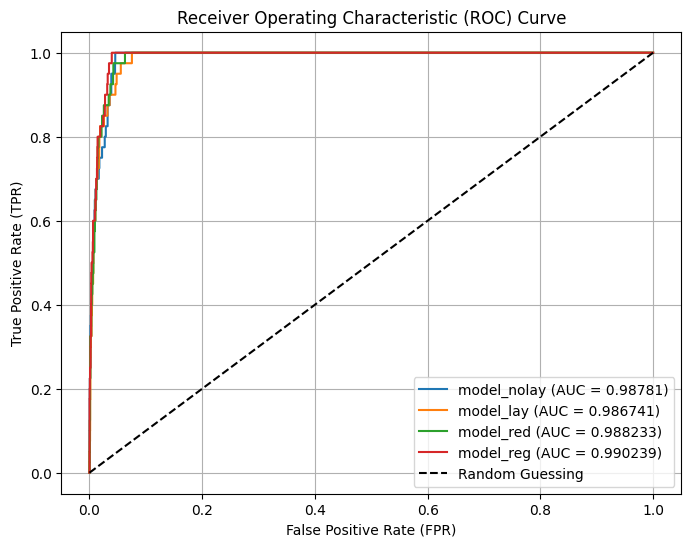

In [ ]:
 # calculate and visualize AUC-ROC curve for NON-REBALANCED models
models = [model_nolay, model_lay, model_red, model_reg]
model_names = ['model_nolay', 'model_lay', 'model_red', 'model_reg']

# Plot ROC curve for each model
plt.figure(figsize=(8, 6))

for model, name in zip(models, model_names):
    # Get model predictions
    y_probs = model.predict(X_test)

    # Ensure y_probs is a 1D array (squeeze it if necessary)
    y_probs = np.squeeze(y_probs)

    # Calculate AUC score
    auc_score = roc_auc_score(y_test, y_probs)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {round(auc_score, 6)})")

# Plot the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

156/156 [==============================] - 0s 2ms/step


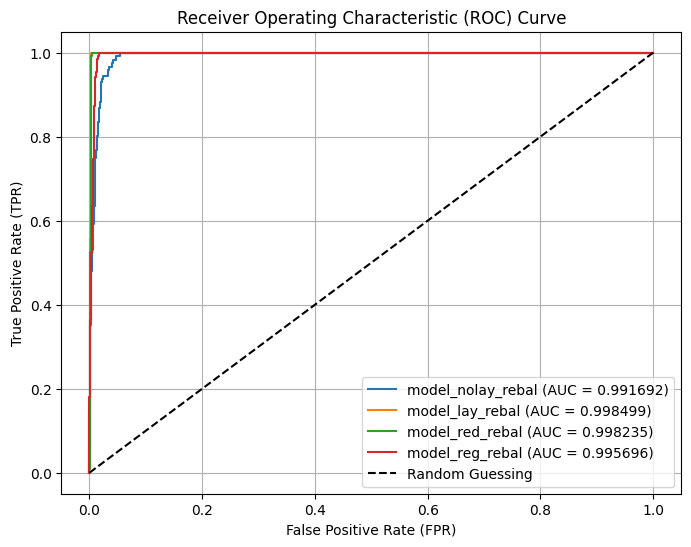

In [ ]:
 # calculate and visualize AUC-ROC curve for REBALANCED models
models_rebal = [model_nolay_rebal, model_lay_rebal, model_red_rebal, model_reg_rebal]
model_names_rebal = ['model_nolay_rebal', 'model_lay_rebal', 'model_red_rebal', 'model_reg_rebal']

# Plot ROC curve for each model
plt.figure(figsize=(8, 6))

for model, name in zip(models_rebal, model_names_rebal):
    # Get model predictions
    y_probs_rebal = model.predict(X_test_rebal)

    # Ensure y_probs is a 1D array (squeeze it if necessary)
    y_probs_rebal = np.squeeze(y_probs_rebal)

    # Calculate AUC score
    auc_score = roc_auc_score(y_test_rebal, y_probs_rebal)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_rebal, y_probs_rebal)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {round(auc_score, 6)})")

# Plot the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()